In [1]:
import numpy as np
import matplotlib.pyplot as plt

def histParam_kin(p_names,names,data,filename):
    for name in p_names:
        var_names = ["px","py","pz"]
        data_mom = data[names == name,5:]
        for j, var_name in enumerate(var_names):
            plt.figure()
            plt.hist(data_mom[:,j], bins=100)
            plt.xlabel(f'{var_name} (keV)')
            plt.ylabel('Counts')
            #plt.yscale('log')
            plt.title(name)
            plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')
        data_E = data[names == name,4]
        data_v = data_mom/data_E[:,np.newaxis]
        var_names2 = ["vx","vy","vz"]
        for j, var_name in enumerate(var_names2):
            plt.figure()
            plt.hist(data_v[:,j], bins=100)
            plt.xlabel(f'{var_name} (c)')
            plt.ylabel('Counts')
            #plt.yscale('log')
            plt.title(name)
            plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')
        if name in ['e+','e-']:
            data_dir = data_v/np.tile(np.linalg.norm(data_v,axis=1),(3,1)).T
            var_names3 = ["x_dir","y_dir","z_dir"]
            for j, var_name in enumerate(var_names3):
                plt.figure()
                plt.hist(data_dir[:,j], bins=100)
                plt.xlabel(f'{var_name}')
                plt.ylabel('Counts')
                #plt.yscale('log')
                plt.title(name)
                plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')

    chargedl_data = data[np.logical_or(names == 'e+',names == 'e-'),5:8]
    neutrino_data = data[np.logical_or(names == 'enu',names == 'enubar'),5:8]
    chargedl_data = chargedl_data/np.tile(np.linalg.norm(chargedl_data,axis=1),(3,1)).T
    neutrino_data = neutrino_data/np.tile(np.linalg.norm(neutrino_data,axis=1),(3,1)).T
    angle = np.sum(chargedl_data*neutrino_data,axis=1)
    plt.figure()
    plt.hist(angle, bins=100)
    plt.xlabel('cos(theta_{e,enu})')
    plt.ylabel('Counts')
    #plt.yscale('log')
    plt.savefig(f'plots/{filename[6:-4]}_angular_correlation_enu_e.pdf')

In [36]:
mass_e = 510.9989461

class data_analysis:
    def __init__(self,fileName,betaType):
        data = np.genfromtxt(fileName, dtype=str)
        self.names = data[:,2]
        self.data = data[:, np.arange(data.shape[1]) != 2].astype(dtype=np.float32)
        self.events = data[:,0].astype(int)
        self.data[np.isnan(self.data)] = 0
        self.c_lepton = "e-" if (betaType == 1) else "e+"
        self.neutrino = "enubar" if (betaType == 1) else "enu"
    def __len__(self):
        return self.data.shape[0]
    def event_mask(self):
        pass
    def kinematical_data(self):
        #energy
        self.data_E_el = self.data[self.names == self.c_lepton ,4]
        
        #directions
        self.data_dir_el = self.data[self.names == self.c_lepton ,5:8]
        self.data_dir_el /= np.tile(np.linalg.norm(self.data_dir_el,axis=1),(3,1)).T
        self.data_dir_enu = self.data[self.names == self.neutrino ,5:8]
        self.data_dir_enu /= np.tile(np.linalg.norm(self.data_dir_enu,axis=1),(3,1)).T
        
        #angle between e and enu
        self.data_angle_elenu = np.sum(self.data_dir_el*self.data_dir_enu,axis=1)
     
    def kinematical_data_ref(self,polDir = np.array([0,0,1])):
        #angles in reference to polDir
        z_cross_elenu = np.sum(np.cross(self.data_dir_el,self.data_dir_enu)*polDir[np.newaxis,:],axis=1)
        self.cos_el = np.sum(self.data_dir_el*polDir[np.newaxis,:],axis=1)
        self.cos_enu = np.sum(self.data_dir_enu*polDir[np.newaxis,:],axis=1)
        sin_el = np.sqrt(1-self.cos_el**2)
        sin_enu = np.sqrt(1-self.cos_enu**2)
        data_cosphi = (self.data_angle_elenu-self.cos_el*self.cos_enu)/sin_el/sin_enu
        data_sinphi = z_cross_elenu/sin_el/sin_enu
        self.data_phi = np.arctan2(data_sinphi,data_cosphi)
    def plot_E_dist(self):
        print(self.data_E_el.size)
        plt.hist(self.data_E_el, bins=100)
        plt.xlabel('E')
        plt.ylabel('Counts')
        #plt.yscale('log')
        plt.title("e-")
        plt.show()
    def theoretical_dist(self, coeffs):
        #note a, c, A, B and D need to be functions dependent on energy
        E_hist, E_bin = np.histogram(self.data_E_el, bins= 200)
        E_vals = (E_bin[1:]+E_bin[:-1])/2
        N = self.data_E_el.size

        z_el = np.linspace(-1,1,201)
        z_nu = z_el.copy()
        z_elenu = z_el.copy()
        phi = np.linspace(-np.pi,np.pi,501)

        self.z_el = z_el
        self.z_nu = z_nu
        self.z_elenu = z_elenu
        self.phi = phi
        
        self.z_el_theory = np.zeros_like(z_el)
        self.z_nu_theory = np.zeros_like(z_nu)
        self.z_elenu_theory = np.zeros_like(z_elenu)
        self.phi_theory = np.zeros_like(phi)

        for E, dist in zip(E_vals, E_hist):
            a, b, c, A, B, D = coeffs(E)
            beta = np.sqrt(1-mass_e**2/E**2)
            self.z_el_theory += dist/N*(1+b*mass_e/E+A*beta*z_el)/2/(1+b*mass_e/E) 
            self.z_elenu_theory += dist/N*(1+b*mass_e/E+a*beta*z_elenu)/2/(1+b*mass_e/E)
            self.z_nu_theory += dist/N*(1+b*mass_e/E+B*z_nu)/2/(1+b*mass_e/E)
            phi_theory_E = dist/N*(1 + b*mass_e/E + beta*((a+c/3)*np.cos(phi)+D*np.sin(phi))*(np.pi/4)**2)
            self.phi_theory += phi_theory_E/2/np.pi/(1+b*mass_e/E)
    def theoretical_dist2(self, coeffs):
        #note a, c, A, B and D need to be functions dependent on energy
        E_hist, E_bin = np.histogram(self.data_E_el, bins= 200)
        E_vals = (E_bin[1:]+E_bin[:-1])/2
        N = self.data_E_el.size

        z_el = np.linspace(-1,1,201)
        z_nu = z_el.copy()
        z_elenu = z_el.copy()
        phi = np.linspace(-np.pi,np.pi,501)

        self.z_el = z_el
        self.z_nu = z_nu
        self.z_elenu = z_elenu
        self.phi = phi
        
        self.z_el_theory2 = np.zeros_like(z_el)
        self.z_nu_theory2 = np.zeros_like(z_nu)
        self.z_elenu_theory2 = np.zeros_like(z_elenu)
        self.phi_theory2 = np.zeros_like(phi)

        for E, dist in zip(E_vals, E_hist):
            a, b, c, A, B, D = coeffs(E)
            beta = np.sqrt(1-mass_e**2/E**2)
            self.z_el_theory2 += dist/N*(1+b*mass_e/E+A*beta*z_el)/2/(1+b*mass_e/E) 
            self.z_elenu_theory2 += dist/N*(1+b*mass_e/E+a*beta*z_elenu)/2/(1+b*mass_e/E)
            self.z_nu_theory2 += dist/N*(1+b*mass_e/E+B*z_nu)/2/(1+b*mass_e/E)
            phi_theory_E = dist/N*(1 + b*mass_e/E + beta*((a+c/3)*np.cos(phi)+D*np.sin(phi))*(np.pi/4)**2)
            self.phi_theory2 += phi_theory_E/2/np.pi/(1+b*mass_e/E)

    def plot_kin_histograms(self,fileName):
        p_names = (set(self.names)&{'e+','e-','enubar','enu'})
        histParam_kin(p_names,self.names,self.data,fileName)
        plt.show()
    def plot_distribution_histograms(self,showTheory=False,compareTheory=False,bins=100):
        plt.hist(self.cos_el, bins=bins,density=True) #z component
        if showTheory:
            plt.plot(self.z_el,self.z_el_theory)
            if compareTheory:
                plt.plot(self.z_el,self.z_el_theory2)
        plt.xlabel("$\\cos \\theta_{e,j}$")
        plt.ylabel('pdf')
        #plt.yscale('log')
        plt.show()
        plt.hist(self.cos_enu, bins=bins,density=True) #z component
        if showTheory: 
            plt.plot(self.z_nu,self.z_nu_theory)
            if compareTheory:
                plt.plot(self.z_nu,self.z_nu_theory2)
        plt.xlabel("$\\cos \\theta_{\\nu,j}$")
        plt.ylabel('pdf')
        #plt.yscale('log')
        plt.show()
        plt.hist(self.data_angle_elenu, bins=bins,density=True)
        if showTheory: 
            plt.plot(self.z_elenu,self.z_elenu_theory)
            if compareTheory:
                plt.plot(self.z_elenu,self.z_elenu_theory2)
        plt.xlabel("$\\cos \\theta_{e,\\nu}$")
        plt.ylabel('pdf')
        #plt.yscale('log')
        plt.show()
        plt.hist(self.data_phi, bins=bins,density=True)
        if showTheory: 
            plt.plot(self.phi,self.phi_theory)
            if compareTheory:
                plt.plot(self.phi,self.phi_theory2)
        plt.xlabel("$\\phi$")
        plt.ylabel('pdf')
        #plt.yscale('log')
        plt.show()
    def plot_2dhist(self,bins=20):
        plt.hist2d(self.cos_el,self.cos_enu,bins=bins)
        plt.colorbar()
        plt.xlabel("$\\cos \\theta_{e,j}$")
        plt.ylabel("$\\cos \\theta_{\\nu,j}$")
        plt.show()
        plt.hist2d(self.cos_el,self.data_phi,bins=bins)
        plt.colorbar()
        plt.xlabel("$\\cos \\theta_{e,j}$")
        plt.ylabel("$\\phi$")
        plt.show()
        plt.hist2d(self.cos_enu,self.data_phi,bins=bins)
        plt.colorbar()
        plt.xlabel("$\\cos \\theta_{\\nu,j}$")
        plt.ylabel("$\\phi$")
        plt.show()

(0.594576644552252, 0.0, -0.24325401326864876, -0.5910195457768667, -0.8342735590455154, 0)
-1.0649315477925323


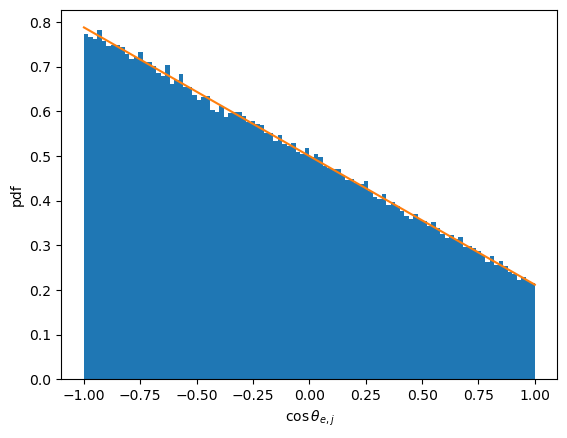

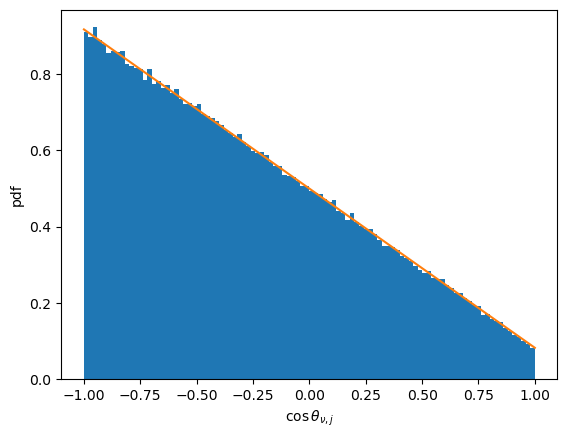

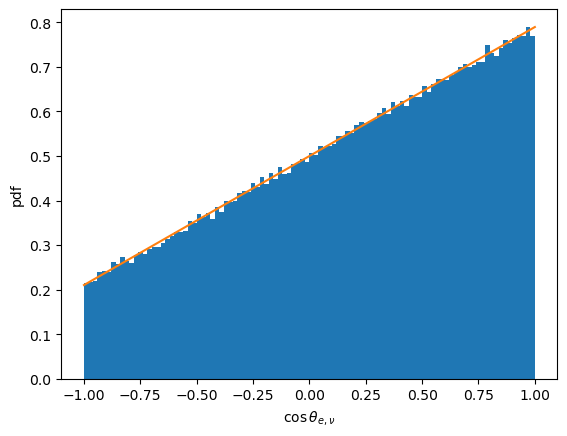

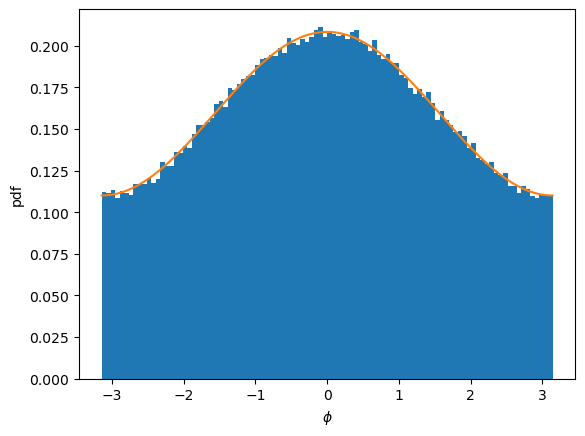

In [37]:
class Ca39_data_analysis(data_analysis):
    def __init__(self, fileName):
        super().__init__(fileName, -1)
    def event_mask(self):
        part_events = np.bincount(self.events)
        events_mask = np.arange(part_events.size)[part_events == 3] #39K + e+ + enu
        self.data = self.data[np.isin(self.events, events_mask),:]
        self.names = self.names[np.isin(self.events, events_mask)]
    
#Standard Model Gamov-Teller

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)

cv = 1
ca = 0.661
lambda_jj = 0.4
Lambda_jj = -4/5

def SM_coeffs(E):
    xi = 2*(cv**2+ca**2)
    a = 2*cv**2-2/3*ca**2
    b = 0
    c = Lambda_jj*2*ca**2
    A = lambda_jj*2*ca**2-np.sqrt(3/5)*4*cv*ca
    B = -lambda_jj*2*ca**2-np.sqrt(3/5)*4*cv*ca
    return (a/xi, b/xi, c/xi, A/xi, B/xi, 0)

a, b, c, A, B, D = SM_coeffs(mass_e)
print((a, b, c, A, B, D))
print(-abs(A)-abs(B)+abs(a-2*c)/3)
   
SM_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_SM.txt")
SM_39Ca_polZpos.event_mask()
SM_39Ca_polZpos.kinematical_data()
SM_39Ca_polZpos.kinematical_data_ref()
SM_39Ca_polZpos.theoretical_dist(SM_coeffs)
SM_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)

(0.5736694322781583, -0.20955468393099835, -0.1597627536860059, -0.5437204549636255, -0.7048380836441172, 0.006662745349686358)


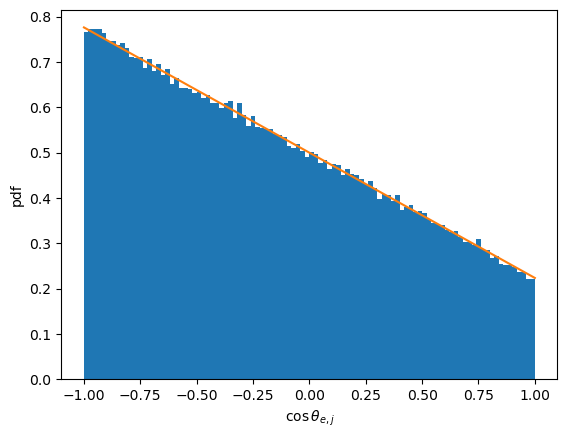

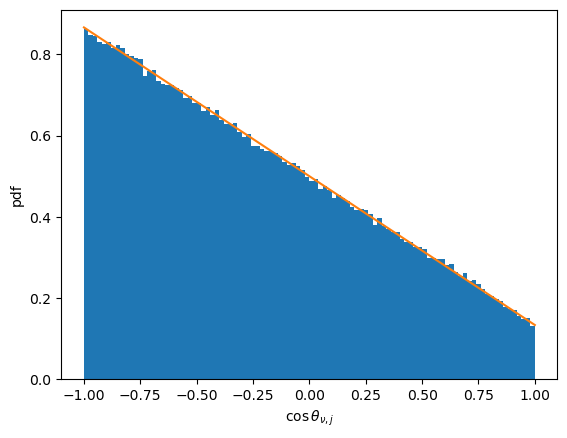

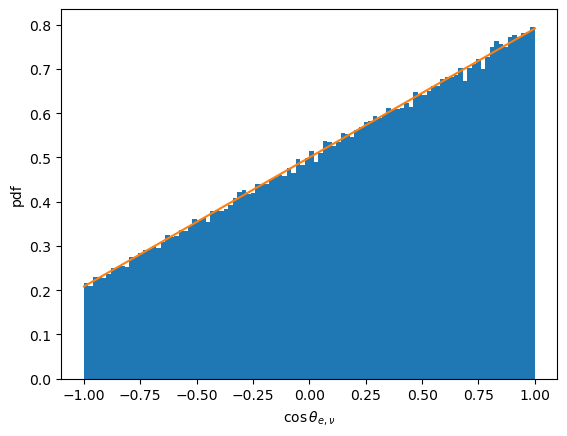

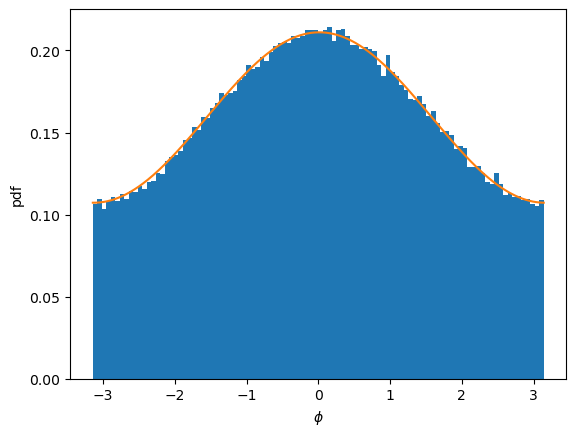

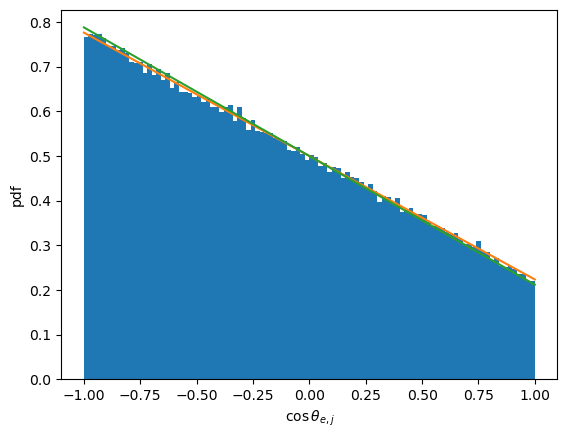

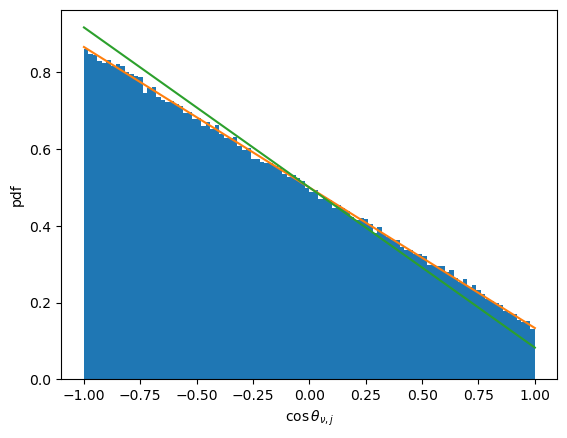

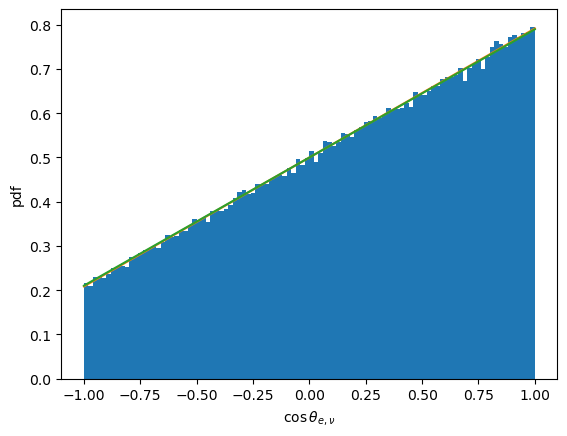

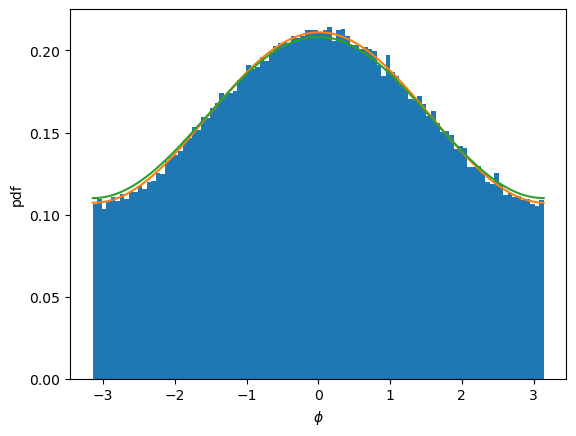

In [43]:
ct = 0.5
Q = 6524.49

def ctre_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2*(cv**2+ca**2)+ct**2
    a = 2*cv**2+1/3*(ct**2-2*ca**2)
    b = -2*gamma*ct*ca
    c = Lambda_jj*(2*ca**2-ct**2)
    A = lambda_jj*2*ca**2-np.sqrt(3/5)*4*cv*ca
    B = -lambda_jj*(2*ca**2-2*gamma*mass_e/E*ca*ct)-np.sqrt(3/5)*(4*cv*ca-2*gamma*mass_e/E*cv*ct)
    D = np.sqrt(3/5)*2*cv*ct*coulombCorr
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

a, b, c, A, B, D = ctre_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CTRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_ctRe.txt")
CTRe_39Ca_polZpos.event_mask()
CTRe_39Ca_polZpos.kinematical_data()
CTRe_39Ca_polZpos.kinematical_data_ref()
CTRe_39Ca_polZpos.theoretical_dist(ctre_coeffs)
CTRe_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CTRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CTRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,bins=100)

(0.5717742202919189, 0.0, -0.16431126245298042, -0.5481089459298247, -0.7675069332810309, 0.0)


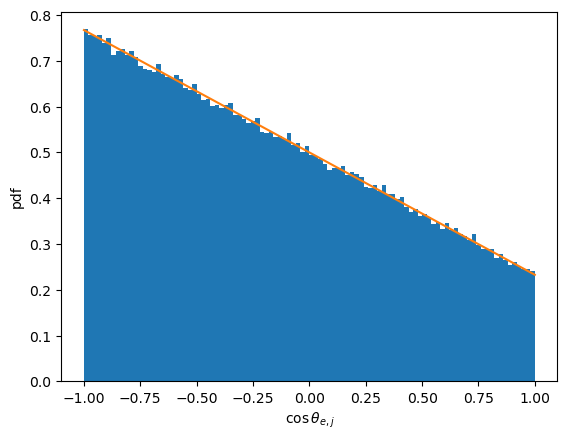

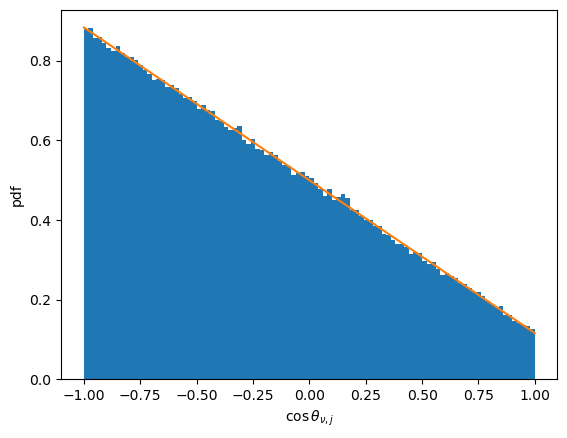

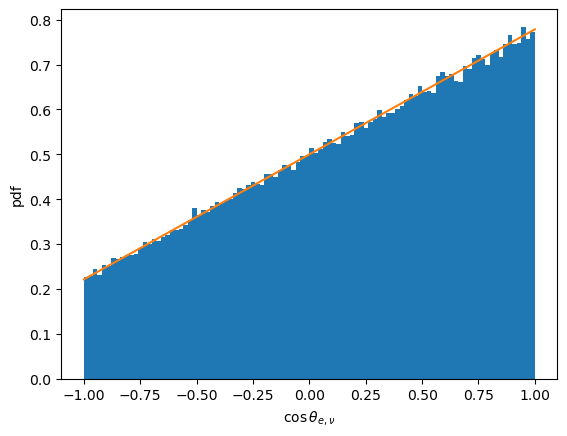

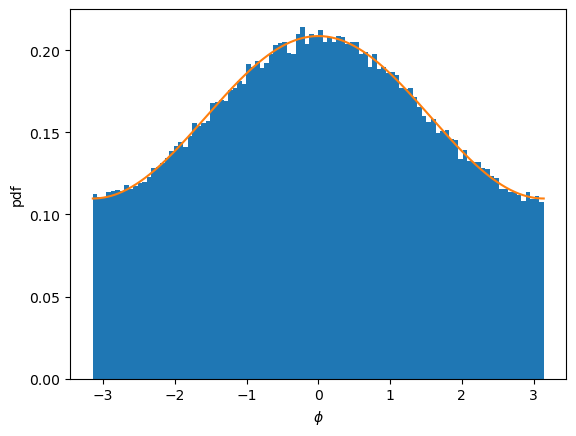

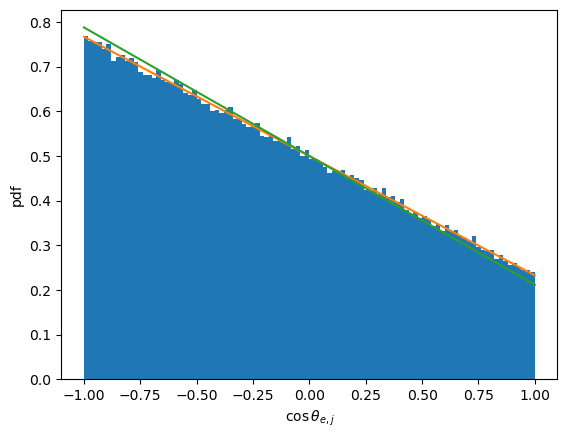

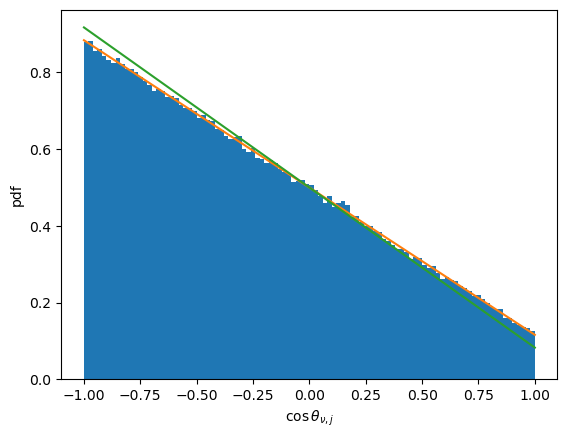

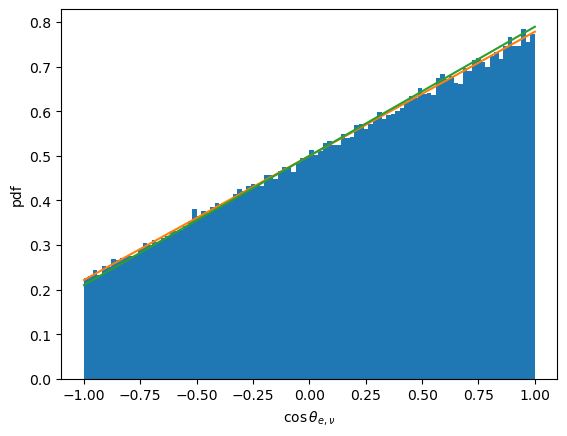

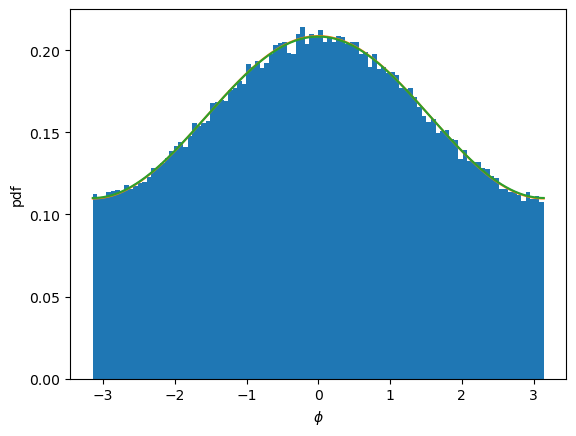

In [52]:
ct = 0.5
Q = 6524.49
Z = 19

def ctIm_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2*(cv**2+ca**2)+ct**2
    a = 2*cv**2+1/3*(ct**2-2*ca**2-2*ct*ca*coulombCorr)
    b = 0
    c = Lambda_jj*(2*ca**2-ct**2+2*ct*ca*coulombCorr)
    A = lambda_jj*(2*ca**2+2*ca*ct*coulombCorr)-np.sqrt(3/5)*(4*cv*ca+2*cv*ct*coulombCorr)
    B = -lambda_jj*(2*ca**2)-np.sqrt(3/5)*(4*cv*ca)
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

a, b, c, A, B, D = ctIm_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CTIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_ctIm.txt")
CTIm_39Ca_polZpos.event_mask()
CTIm_39Ca_polZpos.kinematical_data()
CTIm_39Ca_polZpos.kinematical_data_ref()
CTIm_39Ca_polZpos.theoretical_dist(ctIm_coeffs)
CTIm_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CTIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CTIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,bins=100)

(0.5736694322781583, -0.20955468393099835, -0.1597627536860059, -0.5437204549636255, -0.7048380836441172, 0.006662745349686358)


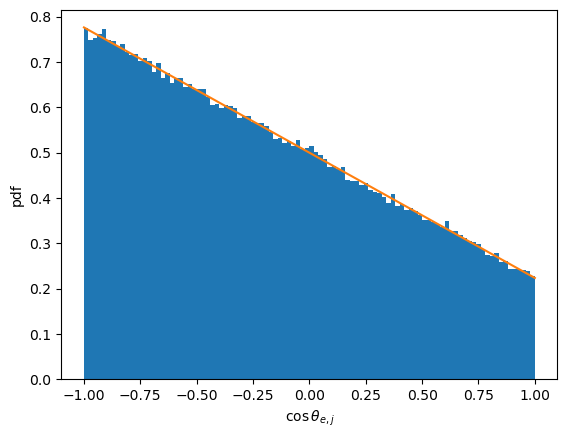

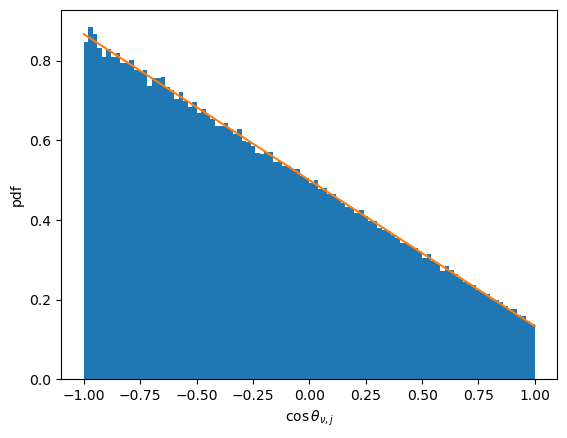

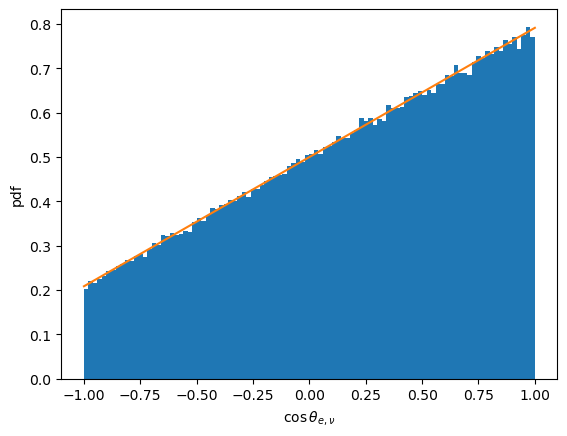

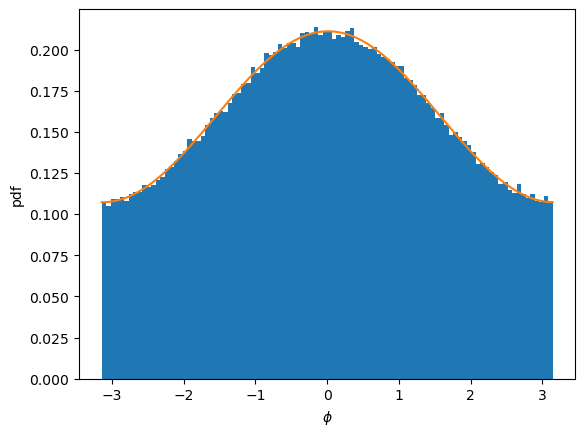

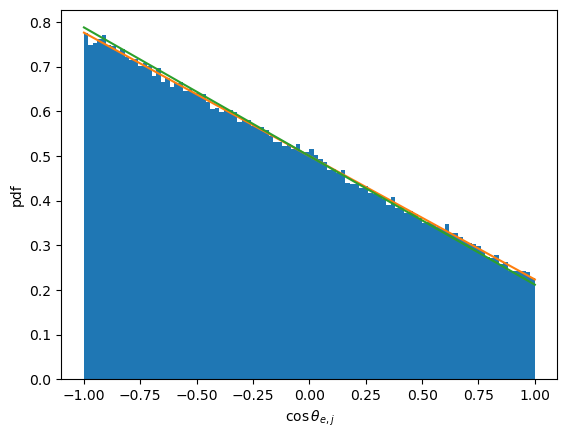

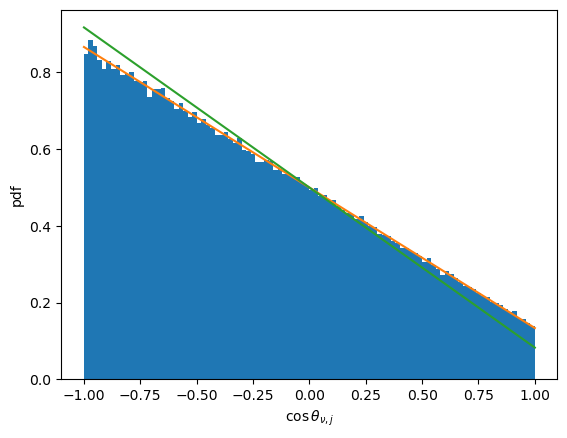

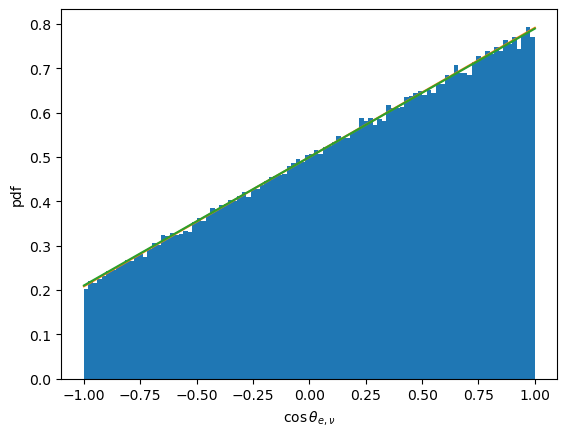

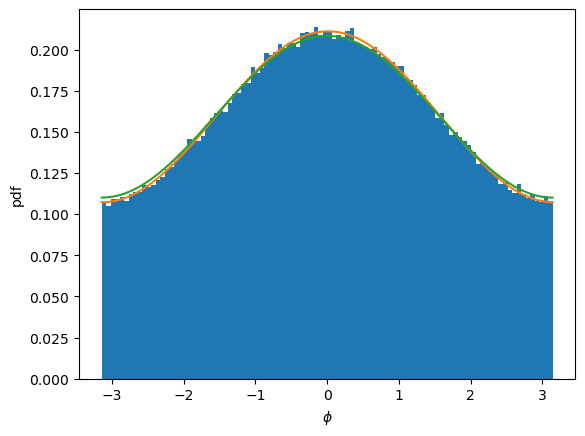

In [49]:
ct = 0.5
Q = 6524.49

a, b, c, A, B, D = ctre_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CTPRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_ctpRe.txt")
CTPRe_39Ca_polZpos.event_mask()
CTPRe_39Ca_polZpos.kinematical_data()
CTPRe_39Ca_polZpos.kinematical_data_ref()
CTPRe_39Ca_polZpos.theoretical_dist(ctre_coeffs)
CTPRe_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CTPRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CTPRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,bins=100)

(0.5717742202919189, 0.0, -0.16431126245298042, -0.5481089459298247, -0.7675069332810309, 0.0)


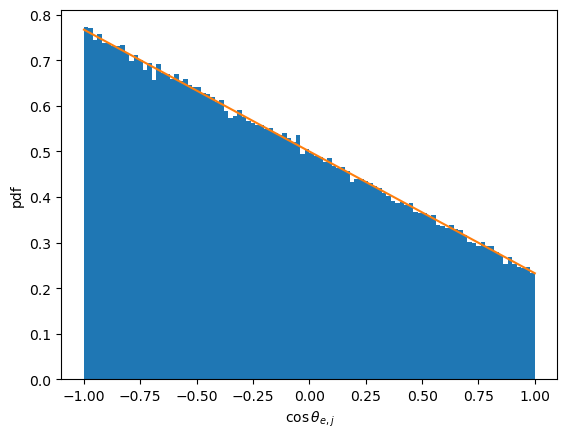

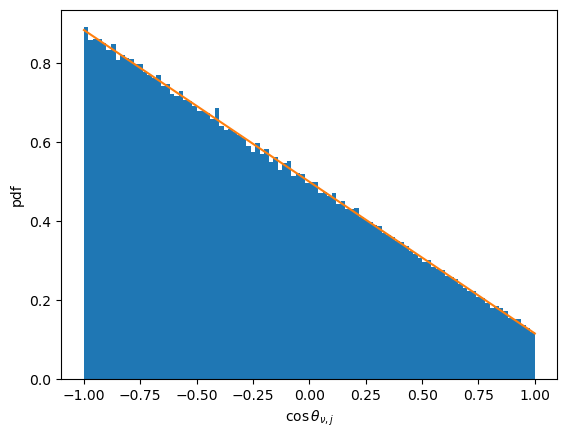

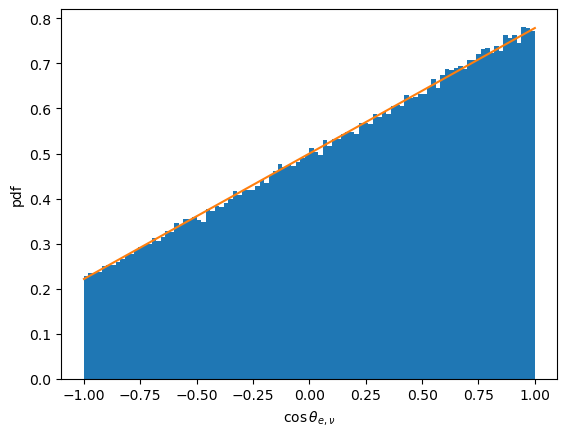

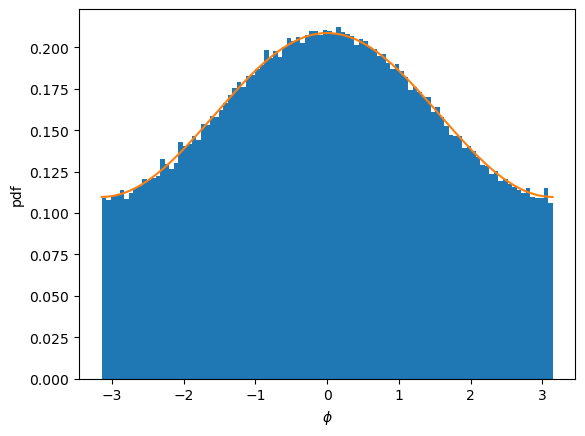

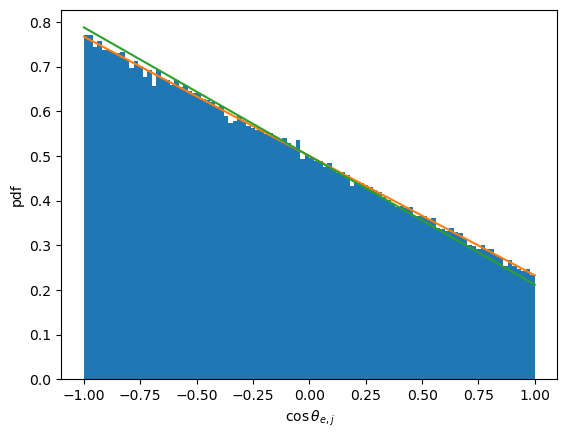

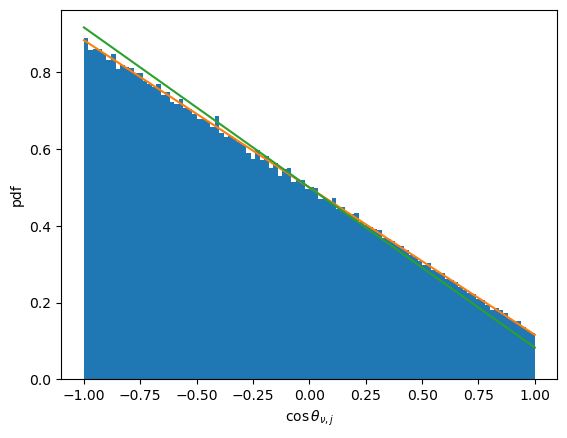

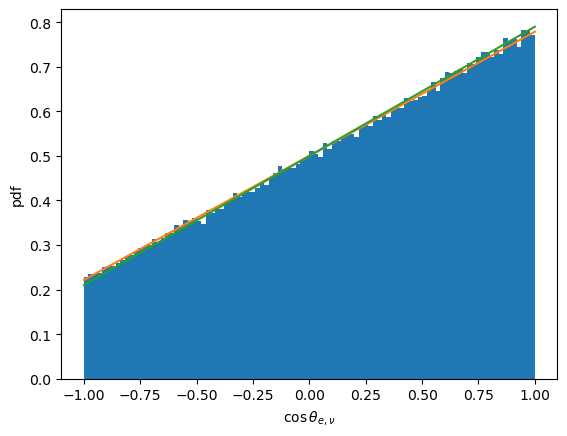

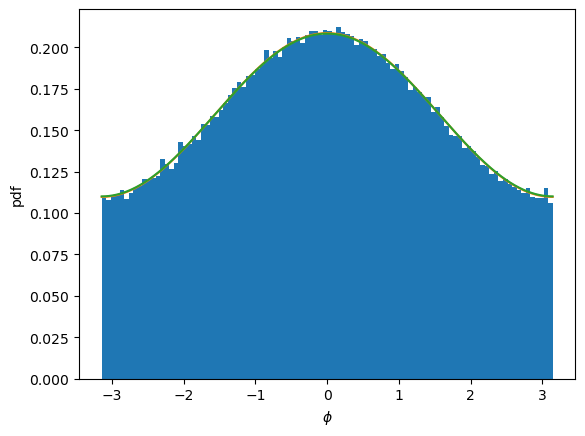

In [53]:
a, b, c, A, B, D = ctIm_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CTPIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_ctpIm.txt")
CTPIm_39Ca_polZpos.event_mask()
CTPIm_39Ca_polZpos.kinematical_data()
CTPIm_39Ca_polZpos.kinematical_data_ref()
CTPIm_39Ca_polZpos.theoretical_dist(ctIm_coeffs)
CTPIm_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CTPIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CTPIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,bins=100)

(0.46696322455915923, -0.31702675329954366, -0.22378647831740534, -0.5437204549636255, -0.720785818930022, -0.004404074676142683)


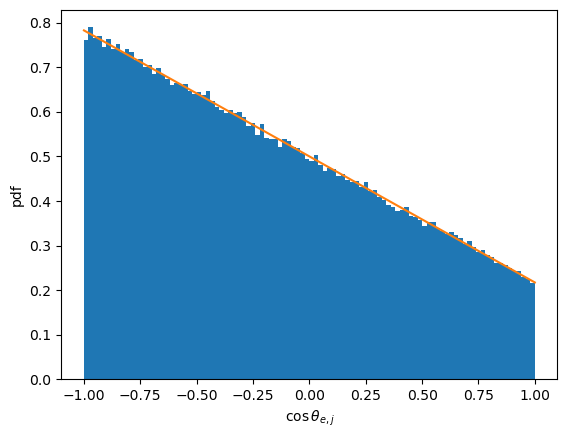

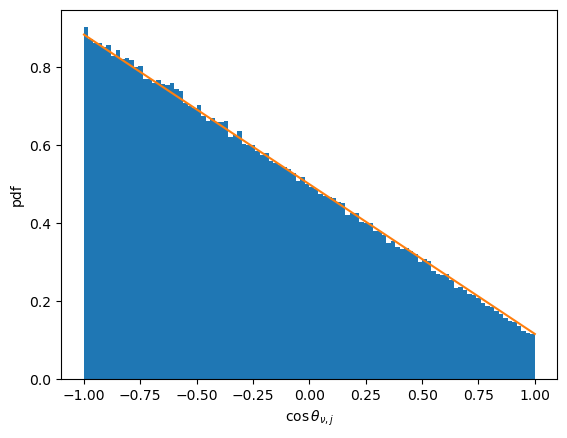

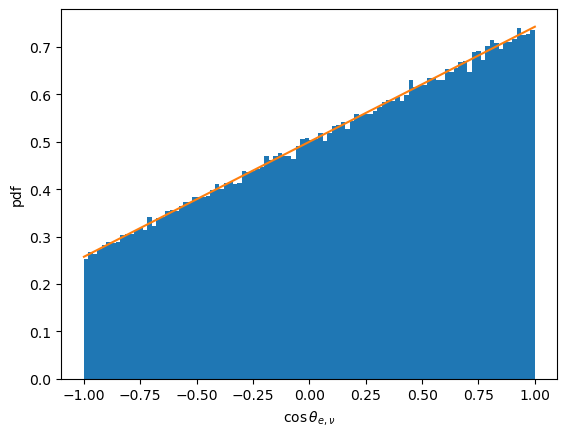

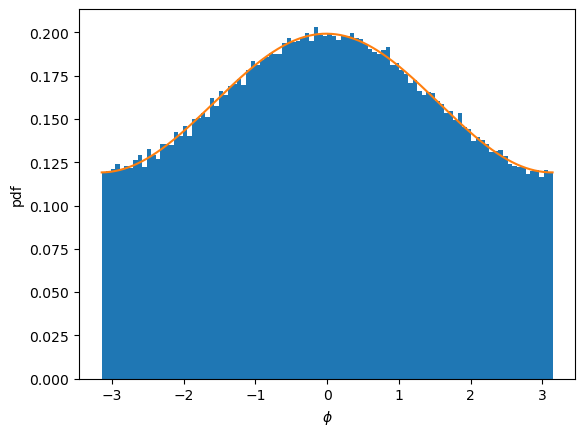

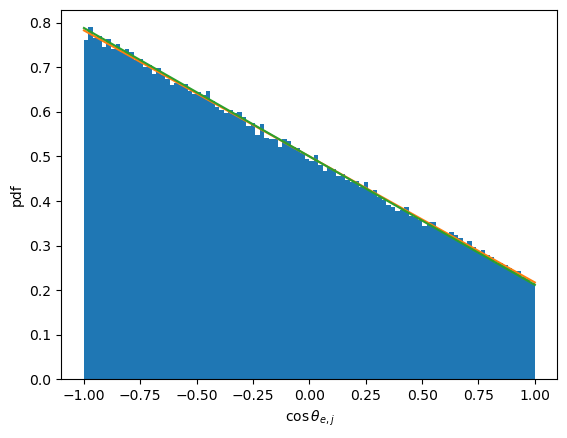

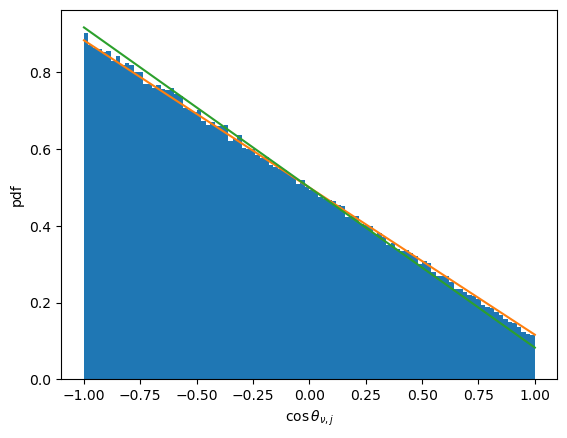

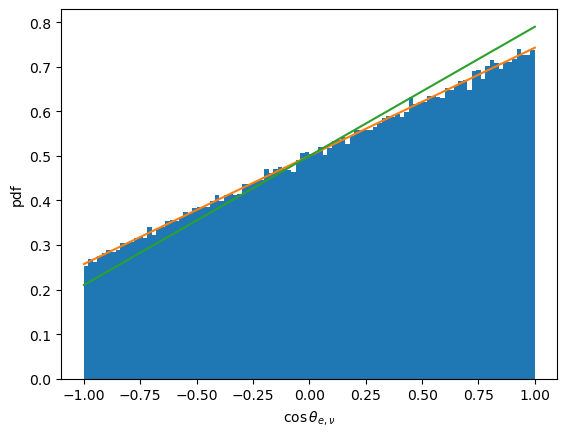

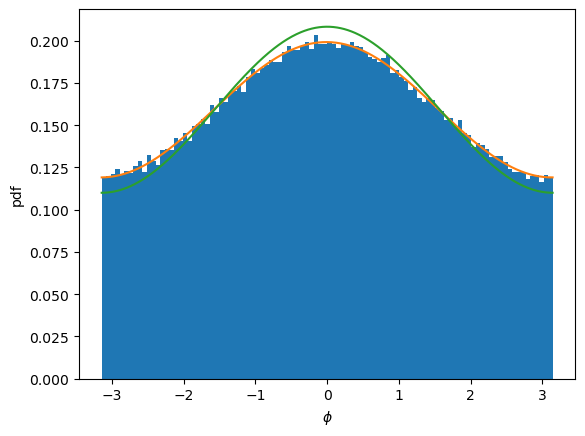

In [57]:
cs = 0.5
Q = 6524.49

def csre_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2*(cv**2+ca**2)+cs**2
    a = 2*cv**2-cs**2+1/3*(-2*ca**2)
    b = -2*gamma*cs*cv
    c = Lambda_jj*(2*ca**2)
    A = lambda_jj*2*ca**2-np.sqrt(3/5)*4*cv*ca
    B = -lambda_jj*(2*ca**2)-np.sqrt(3/5)*(4*cv*ca-2*gamma*mass_e/E*cs*cv)
    D = -np.sqrt(3/5)*2*cs*ca*coulombCorr
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

a, b, c, A, B, D = csre_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CSRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_csRe.txt")
CSRe_39Ca_polZpos.event_mask()
CSRe_39Ca_polZpos.kinematical_data()
CSRe_39Ca_polZpos.kinematical_data_ref()
CSRe_39Ca_polZpos.theoretical_dist(csre_coeffs)
CSRe_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CSRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CSRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,bins=100)

In [ ]:
cs = 0.5
Q = 6524.49
Z = 19

def csIm_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2*(cv**2+ca**2)+cs**2
    a = 2*cv**2-cs**2+2*coulombCorr*cs*cv+1/3*(-2*ca**2)
    b = 0
    c = Lambda_jj*(2*ca**2)
    A = lambda_jj*(2*ca**2+2*ca*ct*coulombCorr)-np.sqrt(3/5)*(4*cv*ca+2*ca*cs*coulombCorr)
    B = -lambda_jj*(2*ca**2)-np.sqrt(3/5)*(4*cv*ca)
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

a, b, c, A, B, D = csIm_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CTIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_csIm.txt")
CTIm_39Ca_polZpos.event_mask()
CTIm_39Ca_polZpos.kinematical_data()
CTIm_39Ca_polZpos.kinematical_data_ref()
CTIm_39Ca_polZpos.theoretical_dist(csIm_coeffs)
CTIm_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CTIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CTIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,bins=100)

(0.4755647918189446, 0.0, -0.22378647831740534, -0.5458502752562809, -0.7675069332810309, 0.0)
